# Text classifcation - transfer learning

https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

In [ ]:
import pandas as pd
import numpy as np
import re
import tweepy
import urllib.request
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import os
import string  
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageFont
import math
from fa2 import ForceAtlas2
import community
import warnings
warnings.filterwarnings("ignore")

from ast import literal_eval


from fastai import *
from fastai.text import *
from pathlib import Path
import re

In [ ]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)


Cuda available
PyTorch version:  1.8.1+cu101


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eng_labelled_tweets_true.csv to eng_labelled_tweets_true.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['eng_labelled_tweets_true.csv']))

#df = pd.read_csv('../Data/eng_labelled_tweets.csv')
df['tokens'] = [literal_eval(s) for s in df['tokens']]
len(df)     

12770

## Pre-process Tweet data for ULMFiT

Removing non-English characters but nothing else

In [ ]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)
df['full_text2'] = df['full_text'].apply(clean_ascii)

In [ ]:
cols2 = ['full_text2','relevant']

df_rel = df[cols2]
print('Rows:',len(df_rel))
display(df_rel.head())

Rows: 12770


,full_text2,relevant
0,Party in Miami tonight! The #Heat have done it...,0
1,Downtown Calgary is now under a controlled eva...,1
2,Is it in poor taste to inform my calgary frien...,1
3,@CPBAbarAB @milktigerlounge so when's my first...,0
4,@Crackmacs same seems like 1/2 of#yyc is shut ...,1


In [ ]:
from sklearn.model_selection import train_test_split
size = [0.3,0.7]

X = df_rel['full_text2']
y = df_rel['relevant']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=size[0], train_size=size[1])


df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['relevant'] = y_train
df_train['text'] = X_train 

df_test['relevant'] = y_test
df_test['text'] = X_test

# Write train to csv
df_train.to_csv('train.csv', index=False, header=False)
df_test.to_csv('test.csv', index=False, header=False)

Language model fine-tuning in ULMFiT

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df('', train_df=df_train, valid_df=df_test,min_freq=1)
data_lm.show_batch()

# Save the language and classifier model data for re-use
data_lm.save()



idx,text
0,"for the kingdom of heaven is like a master of a house who went out early in the morning to hire http : / / t.co / lsrp0vhmlt xxbos xxmaj my love & & thoughts are with all who are being affected by the xxmaj queensland xxmaj flood crisis . xxmaj everyone hold your family & & friends close xxmaj xxx xxbos @warne888 @ronanofficial "" beautiful day "" as long"
1,"damage to a xxmaj burnco xxmaj rock xxmaj products xxmaj ltd. centre and its ... http : / / t.co / k87mhomf9j xxbos xxmaj tuesday morning update : 4st store still closed due to no power in our community . xxmaj closest xxmaj bronze xxmaj baxx is our xxmaj sirocco drive location ! xxbos .@geodesignb # flood barrier now set up in # xxmaj australia too : 1st , #"
2,"of # xxmaj bundaberg , # xxmaj gympie , # burnettheads , # xxup qld # xxmaj brisbane . xxup ru in the area & & affected ? # xxmaj australia # xxmaj queensland # floods xxbos xxmaj public holiday off to a flyer . xxmaj slept in till 6 , eaten 2 breakfasts & & just woke up after my 20 minute nap turned into an hr & &"
3,"get snow ! # missslopes xxbos i saw the news about the flood in xxmaj queensland . xxmaj stay safe , xxmaj aussie friends ! xxbos # blueready news xxmaj city by city , town by town , the rundown of the xxmaj queensland flood crisis - xxmaj herald xxmaj sun http : / / t.co / no4dfngr # xxup breakingnews xxbos i 'm at xxmaj queensland xxmaj tennis xxmaj"
4,hardest hit communities in southern xxmaj alberta ... http : / / t.co / mb66frilvb xxbos @joshhshots i 'm not going to let an ex - cyclone ruin my night xxbos xxup rt @petrecoveryyyc : # yycflood xxup found xxmaj floating in xxup dt # yyc@ xxmaj fish xxmaj creek xxmaj animal xxmaj hospital in the sw.contact xxmaj kim at 403 - 771 - 7225 http : / / t.co


In [ ]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 ':',
 '#',
 '.',
 'http',
 't.co',
 'the',
 'to',
 'flood',
 'in',
 ',']

In [ ]:
# Language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [ ]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(19696, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(19696, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=19696, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


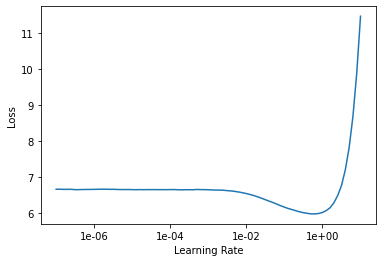

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.895366,3.578619,0.385297,00:14


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.365617,3.445257,0.416819,00:17
1,3.165209,3.414313,0.434259,00:18
2,2.963860,3.408934,0.447166,00:17
3,2.675292,3.500577,0.451931,00:17
4,2.428745,3.627301,0.448932,00:17
5,2.224231,3.736134,0.447933,00:17
6,1.980564,3.850987,0.448001,00:17
7,1.760146,3.905127,0.455726,00:17
8,1.538832,3.980002,0.457919,00:17
9,1.314227,4.069931,0.459103,00:17


In [ ]:
learn.predict('Help us. There has been a flooding',n_words=10)

'Help us. There has been a flooding threatening Calgary , Alberta . # abflood http'

In [ ]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

## Classification

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('', train_df=df_train, valid_df=df_test, vocab=data_lm.train_ds.vocab, min_freq=1,bs=32)
data_clas.save()

In [ ]:
# Classifier
classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8939 items)
x: TextList
xxbos @argybargymufc that 's really good to hear love,xxbos @arianagrande it 's starting to flood in xxmaj australia :o,xxbos # abflood made it onto the front page of xxup bbc . xxmaj stay safe everyone in southern xxmaj alberta ! http : / / t.co / vhm0fyhvf6,xxbos aljazeera : xxmaj deadly flood waters rise in eastern xxmaj australia http : / / t.co / il8jirle,xxbos xxmaj for the kingdom of heaven is like a master of a house who went out early in the morning to hire http : / / t.co / lsrp0vhmlt
y: CategoryList
0,1,1,1,0
Path: .;

Valid: LabelList (3831 items)
x: TextList
xxbos xxmaj power xxmaj out xxmaj for xxmaj the xxmaj second xxmaj time xxmaj in 2 xxmaj hrs :(,xxbos xxmaj edmonton xxmaj trail xxmaj relief xxmaj center has enough volunteers for today . xxmaj thank you . # yycflood,xxbos @wheeler9mike i will look out for you , coz i 'm gunna xxunk and enjoy counting all the tears in the # xxunk end !,xxbos

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


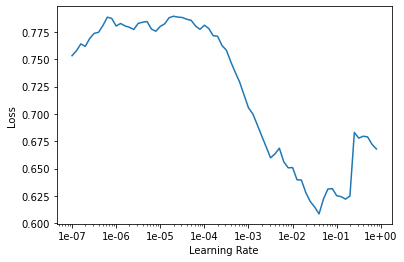

In [ ]:
classifier.lr_find(start_lr=1e-8, end_lr=1e2)
classifier.recorder.plot()

In [ ]:
classifier.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.300155,0.240872,0.909945,00:07


AttributeError: ignored

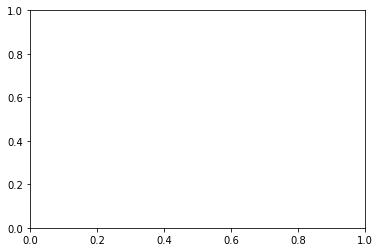

In [ ]:
classifier.recorder.plot_losses()

In [ ]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.287402,0.190429,0.927956,00:08


In [ ]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.254531,0.175412,0.938919,00:12


In [ ]:
classifier.unfreeze()
classifier.fit_one_cycle(5, slice(1e-5,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.113303,0.165859,0.944662,00:17
1,0.120077,0.207653,0.947011,00:16
2,0.099996,0.187314,0.941791,00:17
3,0.094517,0.164102,0.950927,00:17
4,0.071948,0.159236,0.952232,00:16



Confusion matrix
Accuracy: 0.9522317932654659
Precision:  0.9559228650137741
Recall:  0.9598893499308437


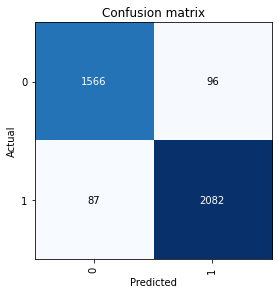

In [ ]:
# get predictions
preds, targets,losses = classifier.get_preds(with_loss=True)
interp =ClassificationInterpretation(classifier,preds, targets, losses)
interp.plot_confusion_matrix()
#predictions = np.argmax(preds, axis=1)
#pd.crosstab(predictions, targets)


print('\nConfusion matrix')
conf_mat = interp.confusion_matrix()
TN =conf_mat[0][0]
FP =conf_mat[0][1]
FN =conf_mat[1][0]
TP =conf_mat[1][1]

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
print('Accuracy:',(acc))
print('Precision: ', prec)
print('Recall: ', rec)

In [ ]:
df_test['text'][:10].apply(lambda row: str(classifier.predict(row)[0]))

2284     0
4742     1
5384     1
5901     1
1726     0
9937     1
1460     0
5670     1
12897    1
11162    1
Name: text, dtype: object